In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Re-Sizing all Images to 224,224**

In [6]:

IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/My Drive/chest_xray/train'
valid_path = '/content/gdrive/My Drive/chest_xray/test'

Adding [3] for rgb channel
using pre-trained weights from imagenet vgg16 model, 
*include_top is *italicized text*set to False for modifying the fully connected layers at the end to tune it according to the classification task in hand*

In [7]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
folders = glob('/content/gdrive/My Drive/chest_xray/train/*')


In [9]:
# Adding customised layers to the output of VGG16
x = Flatten()(vgg.output)

# Additional layers can be added in a similar fashion
# x = Dense(1000, activation='relu')(x)

# Based on the number of classifications, set the final layer in the architecture
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 4894 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Fitting the model.** For this experiment epoch has been set to 3 and steps per epoch and validation have been reduced. 

In [12]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set)//3,
  validation_steps=len(test_set)//3
)



Epoch 1/3
51/51 [==============================] - 936s 18s/step - loss: 0.4167 - accuracy: 0.8523 - val_loss: 0.2459 - val_accuracy: 0.9115
Epoch 2/3
51/51 [==============================] - 929s 18s/step - loss: 0.1210 - accuracy: 0.9516 - val_loss: 0.3384 - val_accuracy: 0.8854
Epoch 3/3
51/51 [==============================] - 928s 18s/step - loss: 0.0991 - accuracy: 0.9626 - val_loss: 0.2564 - val_accuracy: 0.9010


**Plotting losses during training**

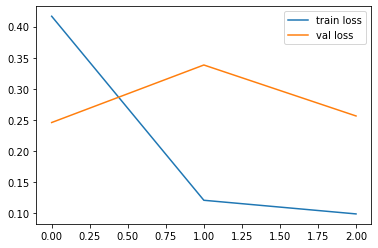

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


**Plotting Accuracies**

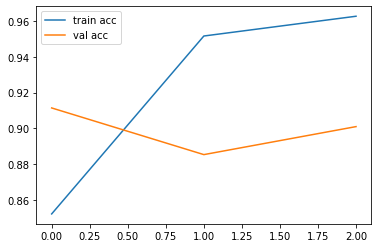

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_Acc')

In [15]:
model.save('/content/gdrive/My Drive/chest_xray/model_vgg16.h5')

# New Section